In [1]:
import numpy as np
import pandas as pd

from scipy.signal import find_peaks
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import to_rgb, to_rgba
matplotlib.rcParams['font.size'] = 8.0

import os
import sys

### <font color='red'><b>Note: User has to specify the number of data files in the directory with the variable `num_data`, the number of events used to calculate the spike probability with the variable `grp`, and also the stimulation pattern used to the variable `ID`.</b></font> 

# Part 0: Preliminary variables (User-specified)

In [2]:
# As for now, we have only six data files and we want to calculate spike probiblity using three events.
# Hence, we will have only two repetitions for this stimulation pattern.
# Make sure that `num_data` / `grp` <= 10.
num_data = 500
grp = 50

In [3]:
# Format of 125 different stimulation patterns:

# Each pattern consists of 3 stimulation events (in temporal order). Let us call these events X,Y, and Z. 
# X,Y,Z in {0,1,2,3,4}
# 0: No stimulation occured
# 1: Stimulation top left
# 2: Stimulation top right
# 3: Stimulation bot right
# 4: Stimulation bot left
# The id (in {0,...,124} is a weighted sum of X,Y,Z: ID = X * 1 + Y * 5 + Z * 25)

# Example: the ID=77 means: X=2,Y=0,Z=3 --> The stimulation pattern consists of a stimulus at top right 
#          for the first time event, no stimulation at second time event, and bottom right for last time event.

In [4]:
ID = 117

# Part 1: Data processing and Finding spikes

In [5]:
dir_inputs = 'C:/Users/yyoon.ces/Desktop/NEURON 8.0 AMD64/Task/volt-data-ID-'
dir_inputs = dir_inputs + str(ID) + '/'

data_tl, data_tr, data_br, data_bl = [], [], [], []

for i in range(num_data):   
    path_tl = os.path.join(dir_inputs, str(i+1) +'_data_tl.txt')
    path_tr = os.path.join(dir_inputs, str(i+1) +'_data_tr.txt')
    path_br = os.path.join(dir_inputs, str(i+1) +'_data_br.txt')
    path_bl = os.path.join(dir_inputs, str(i+1) +'_data_bl.txt')
    
    x = pd.read_csv(path_tl, sep="\t")
    data_tl.append(x)
    x = pd.read_csv(path_tr, sep="\t")
    data_tr.append(x)
    x = pd.read_csv(path_br, sep="\t")
    data_br.append(x)
    x = pd.read_csv(path_bl, sep="\t")
    data_bl.append(x)

In [6]:
for i in range(num_data):
    # renaming the columns
    data_tl[i].columns = ["time", "neuron9", "neuron10", "neuron11"]
    data_tr[i].columns = ["time", "neuron0", "neuron1", "neuron2"]
    data_br[i].columns = ["time", "neuron3", "neuron4", "neuron5"]
    data_bl[i].columns = ["time", "neuron6", "neuron7", "neuron8"]
    
    data_tl[i]['avg'] = data_tl[i][['neuron9', 'neuron10', 'neuron11']].mean(axis=1)
    data_tr[i]['avg'] = data_tr[i][['neuron0', 'neuron1', 'neuron2']].mean(axis=1)
    data_br[i]['avg'] = data_br[i][['neuron3', 'neuron4', 'neuron5']].mean(axis=1)
    data_bl[i]['avg'] = data_bl[i][['neuron6', 'neuron7', 'neuron8']].mean(axis=1)

In [7]:
for i in range(num_data):
    # discard the the first 25 seconds
    data_tl[i] = data_tl[i][1000:2001]
    data_tr[i] = data_tr[i][1000:2001]
    data_br[i] = data_br[i][1000:2001]
    data_bl[i] = data_bl[i][1000:2001]
    
    data_tl[i] = data_tl[i].reset_index(drop=True)
    data_tr[i] = data_tr[i].reset_index(drop=True)
    data_br[i] = data_br[i].reset_index(drop=True)
    data_bl[i] = data_bl[i].reset_index(drop=True)

In [8]:
# calc the avg of voltages from the axons of three neurons
avg_tl, avg_tr, avg_br, avg_bl = [], [], [], []
peaks_tl, peaks_tr, peaks_br, peaks_bl = [], [], [], []

for i in range(num_data):
    avg_tl.append(data_tl[i]["avg"])
    avg_tr.append(data_tr[i]["avg"])
    avg_br.append(data_br[i]["avg"])
    avg_bl.append(data_bl[i]["avg"])
    
    a, _ = find_peaks(data_tl[i]["avg"], height=-55, distance=160)
    peaks_tl.append(a)
    a, _ = find_peaks(data_tr[i]["avg"], height=-55, distance=160)
    peaks_tr.append(a)
    a, _ = find_peaks(data_br[i]["avg"], height=-55, distance=160)
    peaks_br.append(a)
    a, _ = find_peaks(data_bl[i]["avg"], height=-55, distance=160)
    peaks_bl.append(a)

## Sample Plot on Run 01

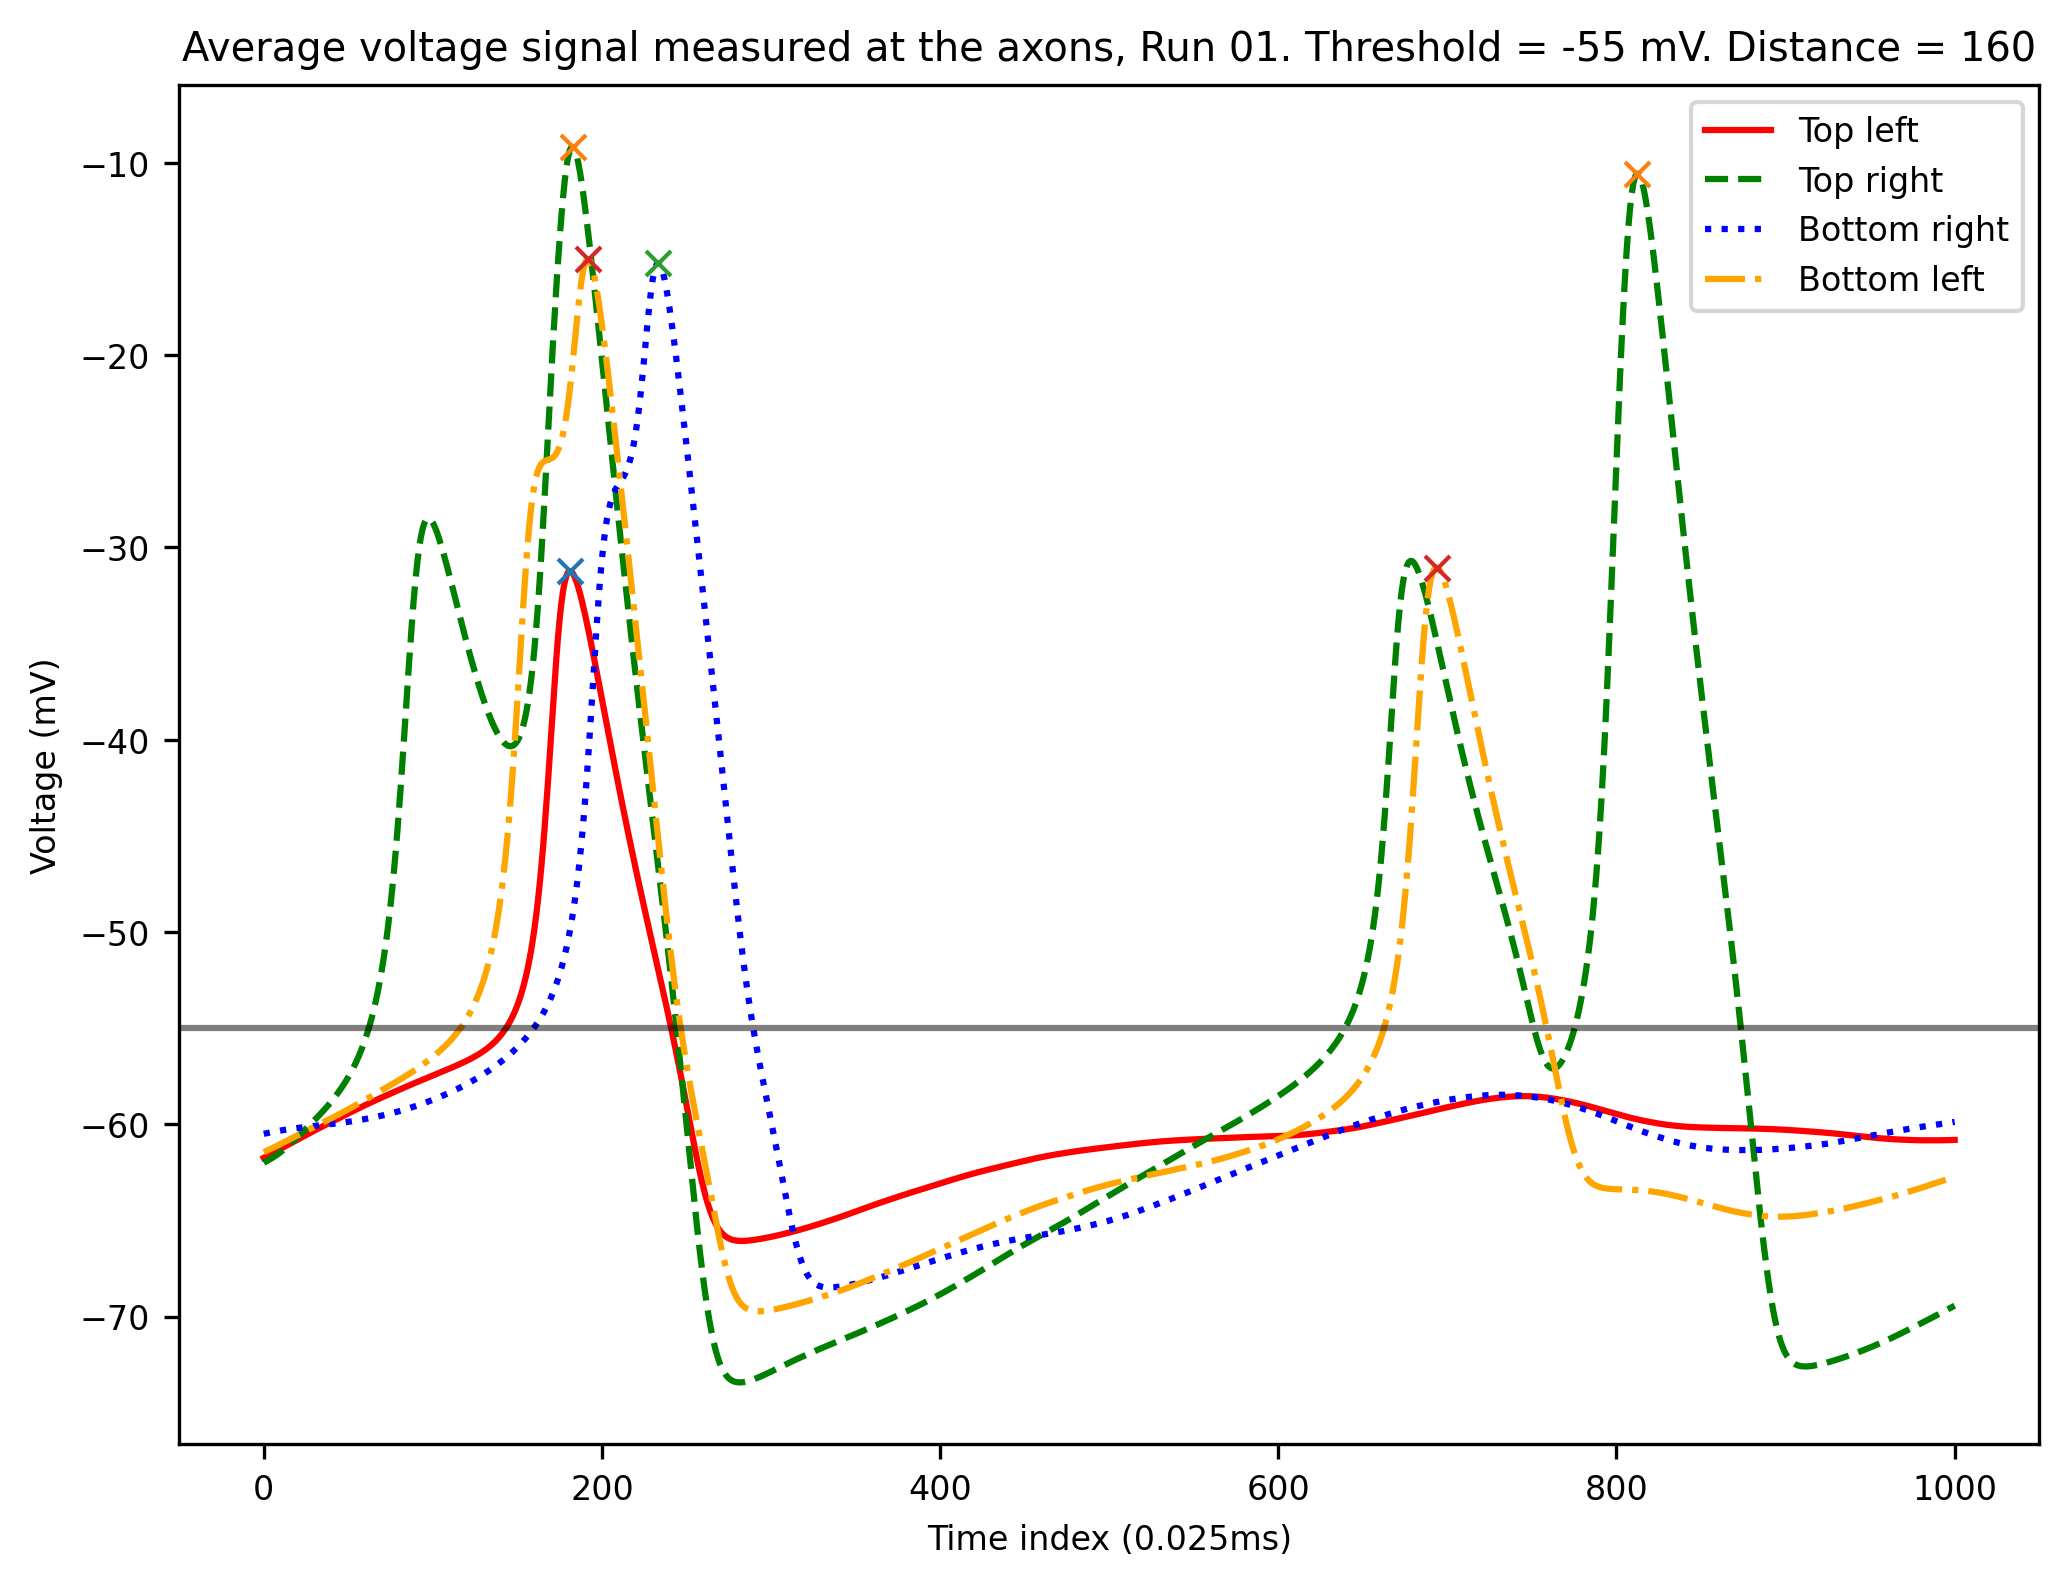

In [9]:
plt.figure(figsize=(8, 6), dpi=300)

plt.plot(data_tl[0]["avg"], color="red", label="Top left", linestyle="solid")
plt.plot(data_tr[0]["avg"], color="green", label="Top right", linestyle="dashed")
plt.plot(data_br[0]["avg"], color="blue", label="Bottom right", linestyle="dotted")
plt.plot(data_bl[0]["avg"], color="orange", label="Bottom left", linestyle="dashdot")

plt.plot(peaks_tl[0], avg_tl[0][peaks_tl[0]], "x")
plt.plot(peaks_tr[0], avg_tr[0][peaks_tr[0]], "x")
plt.plot(peaks_br[0], avg_br[0][peaks_br[0]], "x")
plt.plot(peaks_bl[0], avg_bl[0][peaks_bl[0]], "x")

plt.axhline(y=-55, color='k', linestyle='solid', alpha=0.5)
plt.title("Average voltage signal measured at the axons, Run 01. Threshold = -55 mV. Distance = 160")
plt.xlabel("Time index (0.025ms)")
plt.ylabel("Voltage (mV)")
plt.legend()

#plt.savefig("spike_demo.png", dpi=300)
plt.show()

# Part 2: Calculate spiking probability

## Convert time indices to time units

Note that one index corresponds to 0.025 ms, so 1000 indeces make up for 50 ms.

In [10]:
for j in range(num_data):
    for i in range(len(peaks_tl[j])):
        peaks_tl[j][i] = peaks_tl[j][i] * 0.025
    
    for i in range(len(peaks_tr[j])):
        peaks_tr[j][i] = peaks_tr[j][i] * 0.025
    
    for i in range(len(peaks_br[j])):
        peaks_br[j][i] = peaks_br[j][i] * 0.025
    
    for i in range(len(peaks_bl[j])):
        peaks_bl[j][i] = peaks_bl[j][i] * 0.025

In [11]:
#peaks_br
# number of arrays shows the numbers of data
# whereas the values in each array shows the time unit that the circuit spikes

## Convert numerical peaks to binary values

In [12]:
df = np.zeros((4, 25, num_data))
peaks = [peaks_tl, peaks_tr, peaks_br, peaks_bl]

In [13]:
for i in range(4):
    arr_sub1 = peaks[i]
    for j in range(num_data):
        arr_sub2 = arr_sub1[j]
        for k in range(len(arr_sub2)):
            x = arr_sub2[k]
            df[i][x][j] = 1

In [14]:
np.shape(df)

(4, 25, 500)

## Calculate spike probability

Again as a reminder, user needs to specify how many data inputs are going to be grouped into one in the `grp` variable. In the experimental data, 180 runs were grouped together into one to calculate the spiking probability and we have ten repetitions in total. That is, we have 1800 data assigned into 180 runs per group. Therefore, we have `np.shape(df) = (4, 25, 10)`.

In our simulation case, suppose that we have data on only 6 trials, and we wish to calculate the probability of spike by observing 3 random trials. Then, we have 2 groups as a result, since six trails were divided into three trials per group. Therefore, we have `np.shape(df) = (4, 25, 2)`.

In [15]:
dim1, dim2, dim3 = np.shape(df)

In [16]:
df_prob = []

for i in range(int(dim3/grp)):
    if i == 0:
        df_prob = df[:, :, :grp*(i+1)].mean(axis=2)
        df_prob = np.array(df_prob)
        df_prob = np.expand_dims(df_prob, axis=2)
        #print("dim of df_prob i = 0, ", np.shape(df_prob))
    else:  
        x = df[:, :, grp*(i):grp*(i+1)].mean(axis=2)
        x = np.expand_dims(x, axis=2)
        x = np.array(x)
        #print("dim of x", np.shape(x))
        df_prob = np.concatenate((df_prob, x), axis=2)

In [17]:
np.shape(df_prob)

(4, 25, 10)

Do note that the last dimension is the number of repetitions that we aim to achieve.

# Part 3: Temporal raster plot

## Preparation for self-defined value-dependent alpha values

From this line onwards, we have the similar situation as `Task 4-1 (Experimental Data).ipynb`. 

In [18]:
data_tl, data_tr, data_br, data_bl = df_prob[0], df_prob[1], df_prob[2], df_prob[3]

In [19]:
# data_**_copy will be used to specify the alpha values afterwards
data_tr_copy = data_tr.copy()
data_tl_copy = data_tl.copy()
data_br_copy = data_br.copy()
data_bl_copy = data_bl.copy()

In [20]:
row, col = np.shape(data_tl)

As a cautious reminder, `col` variable is also the number of repetitions while `row` is always fixed at 25 which are the time units.

Now, setting threshold for the probability. Since we have very little data now, we set 0.2 as the threshold temporarily.

In [21]:
thres = 0.2

In [22]:
for i in range(25):
    for j in range(col):
        if data_tl[i][j] >= thres:
            data_tl[i][j] = j + 1
        else:
            data_tl[i][j] = 0
            data_tl_copy[i][j] = 0
            
        if data_tr[i][j] >= thres:
            data_tr[i][j] = j + 1
        else:
            data_tr[i][j] = 0
            data_tr_copy[i][j] = 0
            
        if data_br[i][j] >= thres:
            data_br[i][j] = j + 1
        else:
            data_br[i][j] = 0
            data_br_copy[i][j] = 0

        if data_bl[i][j] >= thres:
            data_bl[i][j] = j + 1
        else:
            data_bl[i][j] = 0
            data_bl_copy[i][j] = 0

In [23]:
# normalise the data_**_copy to [0, 1] so that it matches with the alpha value [0, 1]
min_max_scaler = preprocessing.MinMaxScaler()
data_tr_minmax = min_max_scaler.fit_transform(data_tr_copy)
data_tl_minmax = min_max_scaler.fit_transform(data_tl_copy)
data_br_minmax = min_max_scaler.fit_transform(data_br_copy)
data_bl_minmax = min_max_scaler.fit_transform(data_bl_copy)

In [24]:
rgba_colors_tr = np.zeros((25, col, 4))
rgba_colors_tl = np.zeros((25, col, 4))
rgba_colors_br = np.zeros((25, col, 4))
rgba_colors_bl = np.zeros((25, col, 4))

# the first three columns specift the rgb code (normalised to [0, 1])
rgba_colors_tl[:, :, 0] = 1.0    # red
rgba_colors_tr[:, :, 1] = 1.0    # green
rgba_colors_br[:, :, 2] = 1.0    # blue
rgba_colors_bl[:, :, 0] = 0.980  # orange
rgba_colors_bl[:, :, 1] = 0.313  # orange

for i in range(25):
    alphas_tr = data_tr_minmax[i]
    alphas_tl = data_tl_minmax[i]
    alphas_br = data_br_minmax[i]
    alphas_bl = data_bl_minmax[i]
    
    for j in range(col):
        # the fourth column needs to be your alphas
        rgba_colors_tr[i, j, 3] = alphas_tr[j]
        rgba_colors_tl[i, j, 3] = alphas_tl[j]
        rgba_colors_br[i, j, 3] = alphas_br[j]
        rgba_colors_bl[i, j, 3] = alphas_bl[j]

## Visualisation

In [25]:
lineoffsets1 = [i+1 for i in range(25)]
linelengths = [0.5 for i in range(25)]

x_range = np.linspace(1, 25, 25, endpoint=True)
y_range = np.linspace(1, 10, 10, endpoint=True)
color_set = [rgba_colors_tl, rgba_colors_tr, rgba_colors_br, rgba_colors_bl]

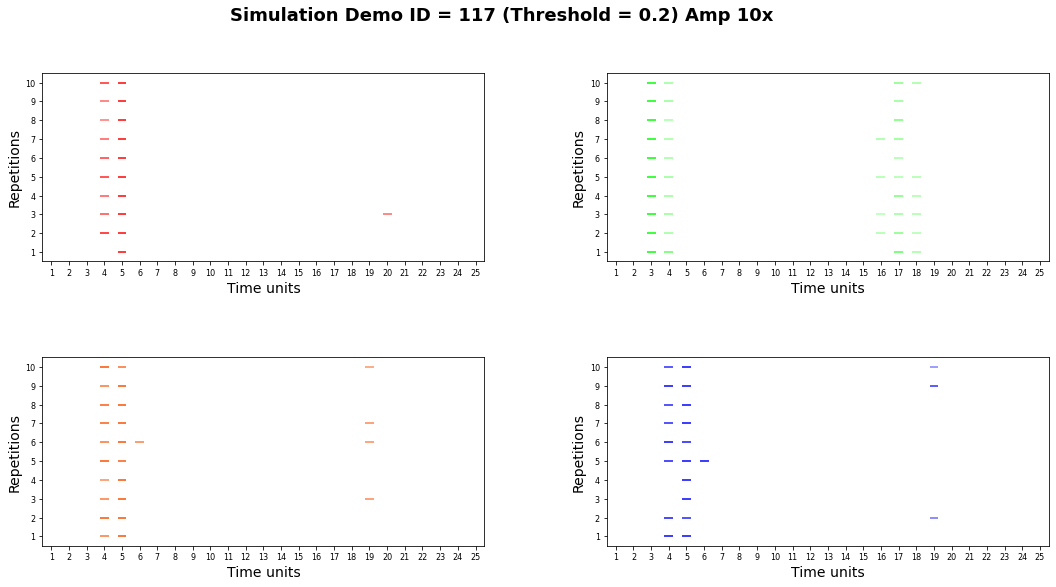

In [26]:
fig, axs = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        if (i == 0 and j == 0):
            data = data_tl
            idx = 0
        if (i == 0 and j == 1):
            data = data_tr
            idx = 1
        if (i == 1 and j == 1):
            data = data_br
            idx = 2
        if (i == 1 and j == 0):
            data = data_bl
            idx = 3
            
        axs[i, j].eventplot(data, 
                            colors=color_set[idx], 
                            lineoffsets=lineoffsets1, 
                            linelengths=linelengths,
                            orientation='vertical')
        
        axs[i, j].set_xlim(0.5, 25.5)
        axs[i, j].set_ylim(0.5, 10.5)
        axs[i, j].set_xticks(x_range)
        axs[i, j].set_yticks(y_range)
        axs[i, j].set_ylabel("Repetitions", fontsize = 14)
        axs[i, j].set_xlabel("Time units", fontsize = 14)

fig.suptitle('Simulation Demo ID = 117 (Threshold = 0.2) Amp 10x', fontweight = "bold", fontsize = 18)
fig.tight_layout()
fig.set_size_inches(16, 9)
fig.savefig('simulation_demo_117_amp_10x.png', dpi=600)

# Recycle Bin

In [27]:
# linelengths1 = [0.8 for i in range(25)]
# linelengths2 = [0.6 for i in range(25)]
# linelengths3 = [0.4 for i in range(25)]
# linelengths4 = [0.2 for i in range(25)]